In [75]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import pickle

## Initializing weights Function

In [76]:
def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer

    # Output:
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""
    np.random.seed(42)
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W

## Sigmoid Function 

In [77]:
def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""
    sig = 1.0 / (1.0 + np.exp(-1.0 * z))
    return sig

## Preprocess Function

In [78]:
def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the
       training set
     test_data: matrix of training set. Each row of test_data contains
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set

     Some suggestions for preprocessing step:
     - feature selection"""
    np.random.seed(42)
    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    # Pick a reasonable size for validation data

    # ------------Initialize preprocess arrays----------------------#
    train_preprocess = np.zeros(shape=(50000, 784))
    validation_preprocess = np.zeros(shape=(10000, 784))
    test_preprocess = np.zeros(shape=(10000, 784))
    train_label_preprocess = np.zeros(shape=(50000,))
    validation_label_preprocess = np.zeros(shape=(10000,))
    test_label_preprocess = np.zeros(shape=(10000,))
    # ------------Initialize flag variables----------------------#
    train_len = 0
    validation_len = 0
    test_len = 0
    train_label_len = 0
    validation_label_len = 0
    # ------------Start to split the data set into 6 arrays-----------#
    for key in mat:
        # -----------when the set is training set--------------------#
        if "train" in key:
            label = key[-1]  # record the corresponding label
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)  # get the length of current training set
            tag_len = tup_len - 1000  # defines the number of examples which will be added into the training set

            # ---------------------adding data to training set-------------------------#
            train_preprocess[train_len:train_len + tag_len] = tup[tup_perm[1000:], :]
            train_len += tag_len

            train_label_preprocess[train_label_len:train_label_len + tag_len] = label
            train_label_len += tag_len

            # ---------------------adding data to validation set-------------------------#
            validation_preprocess[validation_len:validation_len + 1000] = tup[tup_perm[0:1000], :]
            validation_len += 1000

            validation_label_preprocess[validation_label_len:validation_label_len + 1000] = label
            validation_label_len += 1000

            # ---------------------adding data to test set-------------------------#
        elif "test" in key:
            label = key[-1]
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)
            test_label_preprocess[test_len:test_len + tup_len] = label
            test_preprocess[test_len:test_len + tup_len] = tup[tup_perm]
            test_len += tup_len
            # ---------------------Shuffle,double and normalize-------------------------#
    train_size = range(train_preprocess.shape[0])
    train_perm = np.random.permutation(train_size)
    train_data = train_preprocess[train_perm]
    train_data = np.double(train_data)
    train_data = train_data / 255.0
    train_label = train_label_preprocess[train_perm]

    validation_size = range(validation_preprocess.shape[0])
    vali_perm = np.random.permutation(validation_size)
    validation_data = validation_preprocess[vali_perm]
    validation_data = np.double(validation_data)
    validation_data = validation_data / 255.0
    validation_label = validation_label_preprocess[vali_perm]

    test_size = range(test_preprocess.shape[0])
    test_perm = np.random.permutation(test_size)
    test_data = test_preprocess[test_perm]
    test_data = np.double(test_data)
    test_data = test_data / 255.0
    test_label = test_label_preprocess[test_perm]

    # Feature selection
    # Your code here.
    consistent_feature = np.all(train_data == train_data[0, :], axis=0)
    informative_features = np.invert(consistent_feature)
    selected_features = np.where(informative_features)
    print("Number of selected features: ",len(selected_features[0]))

    ## list of selected features have to write code

    # Only keeping the selected features
    train_data = train_data[:, informative_features]
    validation_data = validation_data[:, informative_features]
    test_data = test_data[:, informative_features]

    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features[0]

## NNObjFunction

In [79]:
def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log
    %   likelihood error function with regularization) given the parameters
    %   of Neural Networks, thetraining data, their corresponding training
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.

    % Output:
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden
    %     layer to unit i in output layer."""
    # d = 713

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))  # m * (d+1)
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1))) # 10 * (m+1)
    obj_val = 0

    # Your code here
    n = training_data.shape[0]
    bias_term = np.ones((training_data.shape[0], 1))
    training_data = np.append(training_data, bias_term, 1)

    O1 = np.dot(training_data, np.transpose(w1)) # 50000 * m
    z = sigmoid(O1)  # Output of hidden layer
    z_j = z  # 50000 * m - without bias term
    bias_term = np.ones((z.shape[0], 1)) # adding a bias term to the hidden layer
    z = np.append(z, bias_term, 1)  # 50000 * m+1
    O2 = np.dot(z, np.transpose(w2))  # 50000 * 10
    Op = sigmoid(O2)  # 50000 * 10

    # 1-of-K coding scheme of input data
    y = np.zeros([training_label.shape[0], n_class])
    y[np.arange(training_label.shape[0]), training_label.astype(int)] = 1.0

    J_error =  np.sum(np.multiply(y, np.log(Op)) + np.multiply((1 - y), np.log((1-Op)))) * (-1 / n_input) # change n_input
    reg_term = (lambdaval / (2 * n_input)) * (np.sum(np.square(w1)) + np.sum(np.square(w2))) # equation 15
    # J_Regularization = J_error + reg_term
    obj_val = J_error + reg_term

    # Backpropagation
    delta_l = Op - y # 50000 * 10
    dJ_dw2 = np.dot(np.transpose(delta_l), z)  # 10 * m+1
    dJRegularization_dw2 = (dJ_dw2 + lambdaval * w2) / n  # equation 16
    grad_w2 = dJRegularization_dw2

    # considering the weights and z without bias
    # term1 = np.dot(delta_l, w2[:, :-1]) * (z_j * (1 - z_j))  # 50000 * m
    term1 = ((1 - z_j) * z_j) * (np.dot(delta_l, w2[:, :-1]))  # 50000 * m
    dJ_dw1 = np.dot(np.transpose(term1), training_data)
    dJRegularization_dw1 = (dJ_dw1 + lambdaval * w1) / n # m*714 (considering selected features from preprocess)  --- # equation 17
    grad_w1 = dJRegularization_dw1

    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)

    # obj_grad = np.array([])

    return (obj_val, obj_grad)


## NNPredict Function

In [80]:
def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature
    %       vector of a particular image

    % Output:
    % label: a column vector of predicted labels"""
    # Your code here
    bias_column = np.ones((data.shape[0], 1))
    data = np.append(data, bias_column, 1)
    Oh = np.dot(data, np.transpose(w1))
    z1 = sigmoid(Oh)
    bias_column = np.ones((z1.shape[0], 1))
    z1 = np.append(z1, bias_column, 1)  # Add bias term
    Op = np.dot(z1, np.transpose(w2))
    Out_Class = sigmoid(Op)
    labels = np.argmax(Out_Class, axis=1)
    return labels

# **Preprocessing the data**

In [81]:
"""**************Neural Network Script Starts here********************************"""

train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features = preprocess()

Number of selected features:  710
preprocess done


# **Hyperparameter Tuning** 

Step 1: Increasing the lambda value and keeping the number of hidden nodes 20 **constant** to check the accuracy variation according to lambda

In [ ]:
n_input = train_data.shape[1]
n_class = 10

In [82]:
#  Train Neural Network
# Set the number of nodes in input and output units
n_input = train_data.shape[1]
n_hidden = 20  # Fixed number of hidden units
# Lambda values to test
lambda_vals = range(0, 65, 5)

val_lambda_result = []

# Iterate over different lambda values
for lambdaval in lambda_vals:
    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Set up arguments and options for training
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    opts = {'maxiter': 50}  # Preferred max iteration count

    # Train the neural network
    start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    runtime = time.time() - start_time

    # Reshape nn_params into weight matrices w1 and w2
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Test on validation data
    predicted_label = nnPredict(w1, w2, validation_data)
    accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))

    # Store results
    val_lambda_result.append((lambdaval, accuracy, runtime))
    print(f'Lambda: {lambdaval}, Validation Accuracy: {accuracy:.2f}%, Runtime: {runtime:.2f}s')


Lambda: 0, Validation Accuracy: 92.97%, Runtime: 44.08s
Lambda: 5, Validation Accuracy: 92.95%, Runtime: 40.73s
Lambda: 10, Validation Accuracy: 92.88%, Runtime: 33.29s
Lambda: 15, Validation Accuracy: 92.87%, Runtime: 34.48s
Lambda: 20, Validation Accuracy: 92.81%, Runtime: 33.16s
Lambda: 25, Validation Accuracy: 92.88%, Runtime: 33.96s
Lambda: 30, Validation Accuracy: 92.68%, Runtime: 34.75s
Lambda: 35, Validation Accuracy: 92.70%, Runtime: 34.89s
Lambda: 40, Validation Accuracy: 92.54%, Runtime: 34.81s
Lambda: 45, Validation Accuracy: 92.47%, Runtime: 33.89s
Lambda: 50, Validation Accuracy: 92.28%, Runtime: 37.12s
Lambda: 55, Validation Accuracy: 92.14%, Runtime: 34.33s
Lambda: 60, Validation Accuracy: 92.10%, Runtime: 34.75s


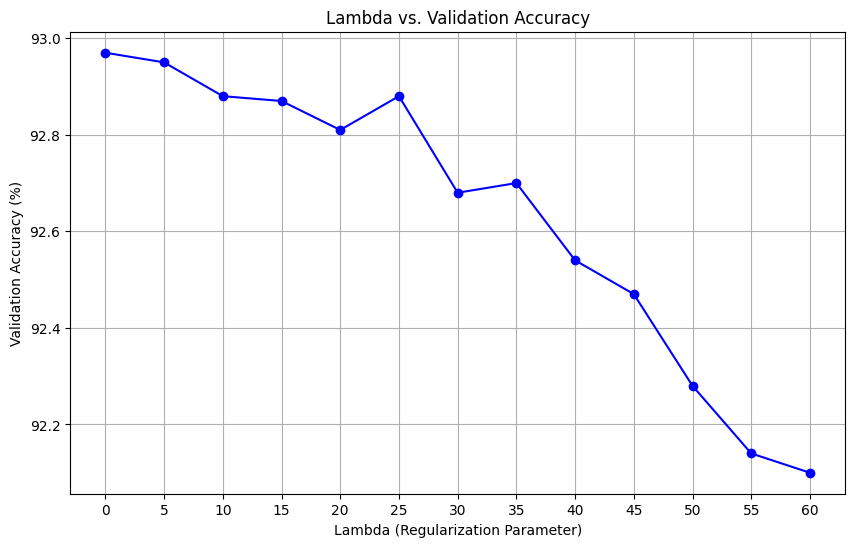

In [83]:
lambda_vals = [result[0] for result in val_lambda_result]
accuracies = [result[1] for result in val_lambda_result]

# Plot Lambda vs. Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.title("Lambda vs. Validation Accuracy")
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)
plt.xticks(lambda_vals)

plt.show()


Notes : Optimal Lambda values are 5, 10 and 25. Taking 10 as lambda

Step 2: Increasing the Number of hidden nodes and keeping the lambda value constant 10 to check the accuracy and run time variation according to hidden nodes

In [88]:
lambdaval = 10

# Hidden node values to test
hidden_nodes_vals = [4, 8, 12, 16, 20, 50]

# Results storage: list to hold lambda, accuracy, and runtime for each setting
val_hidden_result = []

# Iterate over different hidden node values
for n_hidden in hidden_nodes_vals:

    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Set up arguments and options for training
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    opts = {'maxiter': 50}  # Preferred max iteration count

    # Train the neural network
    start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    runtime = time.time() - start_time

    # Reshape nn_params into weight matrices w1 and w2
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Test on validation data
    predicted_label = nnPredict(w1, w2, validation_data)
    accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))

    # Store results
    val_hidden_result.append((n_hidden, accuracy, runtime))
    print(f'Hidden Nodes: {n_hidden}, Validation Accuracy: {accuracy:.2f}%, Runtime: {runtime:.2f}s')


Hidden Nodes: 4, Validation Accuracy: 74.89%, Runtime: 29.63s
Hidden Nodes: 8, Validation Accuracy: 89.47%, Runtime: 26.70s
Hidden Nodes: 12, Validation Accuracy: 90.72%, Runtime: 28.60s
Hidden Nodes: 16, Validation Accuracy: 92.53%, Runtime: 31.41s
Hidden Nodes: 20, Validation Accuracy: 92.88%, Runtime: 34.13s
Hidden Nodes: 50, Validation Accuracy: 94.53%, Runtime: 45.63s


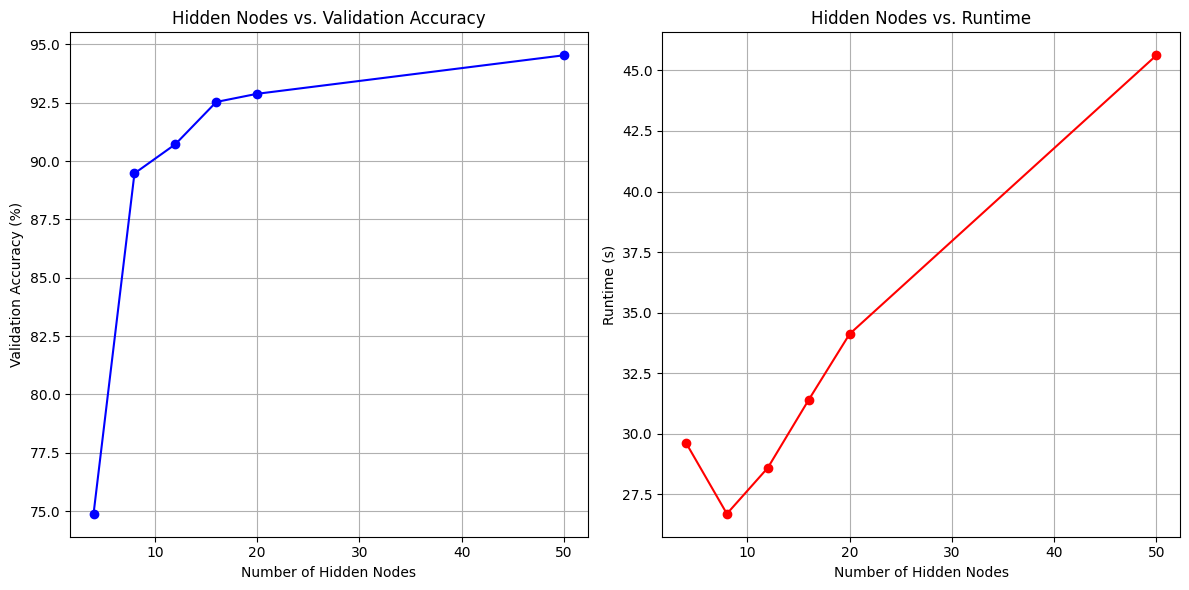

In [89]:
hidden_nodes = [result[0] for result in val_hidden_result]
accuracies = [result[1] for result in val_hidden_result]
runtimes = [result[2] for result in val_hidden_result]

plt.figure(figsize=(12, 6))

# Plot validation accuracy vs. hidden nodes
plt.subplot(1, 2, 1)
plt.plot(hidden_nodes, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.title("Hidden Nodes vs. Validation Accuracy")
plt.xlabel("Number of Hidden Nodes")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)

# Plot runtime vs. hidden nodes
plt.subplot(1, 2, 2)
plt.plot(hidden_nodes, runtimes, marker='o', linestyle='-', color='r', markersize=6)
plt.title("Hidden Nodes vs. Runtime")
plt.xlabel("Number of Hidden Nodes")
plt.ylabel("Runtime (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

Hidden nodes = 20 gives a very high accuracy (92.88%) with a relatively reasonable runtime (34.13s), which is a good balance.

Step 3: Running every Combination of lambda with number of hidden nodes to check whether the optimal values we achieved that is lambda 10 and hidden nodes 20 are the correct values.

In [90]:
lambda_vals = range(0, 65, 5)
hidden_units = [4, 8, 12, 16, 20]

# Store the results
best_accuracy = 0
best_params = None
val_combination_result = []

# Grid search over lambda_vals and hidden_units
for lambdaval in lambda_vals:
    for n_hidden in hidden_units:

        initial_w1 = initializeWeights(n_input, n_hidden)
        initial_w2 = initializeWeights(n_hidden, n_class)
        initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

        # Set up the arguments for training
        args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

        # Set the options for minimize
        opts = {'maxiter': 50}

        # Start timing this iteration
        start_time = time.time()

        # Train the neural network
        nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

        # Get runtime for this combination
        runtime = time.time() - start_time

        # Reshape the nn_params into weight matrices w1 and w2
        w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
        w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

        # Predict labels on validation data
        predicted_label = nnPredict(w1, w2, validation_data)

        # Calculate validation accuracy
        accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))

        # Store the results
        val_combination_result.append((lambdaval, n_hidden, accuracy, runtime))

        # Update the best parameters if the current accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (lambdaval, n_hidden)

        print(f'Lambda: {lambdaval}, Hidden Units: {n_hidden}, Validation Accuracy: {accuracy:.2f}%, Runtime: {runtime:.2f}s')

# Finalize the best hyperparameters
print(f'\nBest Hyperparameters - Lambda: {best_params[0]}, Hidden Units: {best_params[1]}, Validation Accuracy: {best_accuracy:.2f}%')



Lambda: 0, Hidden Units: 4, Validation Accuracy: 74.95%, Runtime: 32.72s
Lambda: 0, Hidden Units: 8, Validation Accuracy: 89.25%, Runtime: 31.17s
Lambda: 0, Hidden Units: 12, Validation Accuracy: 90.36%, Runtime: 28.97s
Lambda: 0, Hidden Units: 16, Validation Accuracy: 92.37%, Runtime: 34.73s
Lambda: 0, Hidden Units: 20, Validation Accuracy: 92.97%, Runtime: 33.45s
Lambda: 5, Hidden Units: 4, Validation Accuracy: 74.80%, Runtime: 29.44s
Lambda: 5, Hidden Units: 8, Validation Accuracy: 89.48%, Runtime: 26.92s
Lambda: 5, Hidden Units: 12, Validation Accuracy: 90.66%, Runtime: 28.47s
Lambda: 5, Hidden Units: 16, Validation Accuracy: 92.26%, Runtime: 31.64s
Lambda: 5, Hidden Units: 20, Validation Accuracy: 92.95%, Runtime: 34.03s
Lambda: 10, Hidden Units: 4, Validation Accuracy: 74.89%, Runtime: 28.59s
Lambda: 10, Hidden Units: 8, Validation Accuracy: 89.47%, Runtime: 27.36s
Lambda: 10, Hidden Units: 12, Validation Accuracy: 90.72%, Runtime: 29.02s
Lambda: 10, Hidden Units: 16, Validation 

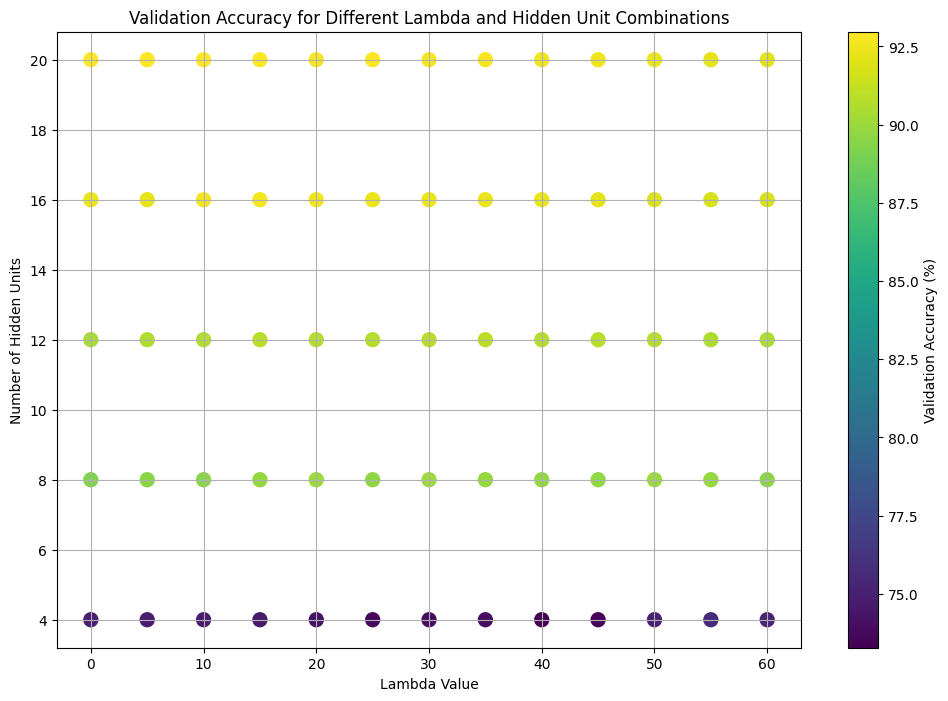

In [94]:
# Plot the validation accuracies for each combination
plt.figure(figsize=(12, 8))

# Prepare the data for plotting
lambdas = [result[0] for result in val_combination_result]
n_hiddens = [result[1] for result in val_combination_result]
accuracies = [result[2] for result in val_combination_result]

plt.scatter(lambdas, n_hiddens, c=accuracies, cmap='viridis', s=100)
plt.colorbar(label='Validation Accuracy (%)')
plt.xlabel('Lambda Value')
plt.ylabel('Number of Hidden Units')
plt.title('Validation Accuracy for Different Lambda and Hidden Unit Combinations')
plt.grid(True)
plt.savefig("MLoutput1", bbox_inches="tight")
plt.show()

## optimal lambda chosen is 10 and hidden nodes is 20 as they are giving a good accuracy
## Lambda: 10, Hidden Units: 20, Validation Accuracy: 92.88%, Runtime: 39.69s

Training and Testing the model with optimal lambda and hidden nodes values

In [95]:
# Train and test the model with the best parameters
n_input = train_data.shape[1]
lambdaval = 10
n_hidden = 20

initial_w1 = initializeWeights(n_input, n_hidden)
initial_w2 = initializeWeights(n_hidden, n_class)
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

# Train with the best hyperparameters
nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

# Reshape weights
w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

# Calculate accuracies
predicted_label_train = nnPredict(w1, w2, train_data)
print('\nTraining set Accuracy:', 100 * np.mean((predicted_label_train == train_label).astype(float)), '%')

predicted_label_test = nnPredict(w1, w2, test_data)
print('\nTest set Accuracy:', 100 * np.mean((predicted_label_test == test_label).astype(float)), '%')

dump_obj = [selected_features, n_hidden, lambdaval, w1, w2]
print(dump_obj)
pickle.dump(dump_obj, open('params.pickle', 'wb'))



Training set Accuracy: 93.74 %

Test set Accuracy: 93.47 %
[array([ 12,  13,  14,  15,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
   

In [96]:
# Calculate accuracies
predicted_label_train = nnPredict(w1, w2, train_data)
print('\nTraining set Accuracy:', 100 * np.mean((predicted_label_train == train_label).astype(float)), '%')

predicted_label_test = nnPredict(w1, w2, test_data)
print('\nTest set Accuracy:', 100 * np.mean((predicted_label_test == test_label).astype(float)), '%')

predicted_label_val = nnPredict(w1, w2, validation_data)
print('\nValidation set Accuracy:', 100 * np.mean((predicted_label_val == validation_label).astype(float)), '%')


Training set Accuracy: 93.74 %

Test set Accuracy: 93.47 %

Validation set Accuracy: 92.88 %


In [98]:
from sklearn.metrics import confusion_matrix

predicted_test_label = nnPredict(w1, w2, test_data)

conf_matrix = confusion_matrix(test_label, predicted_test_label)
print("\nConfusion Matrix on Test Set:")
print(conf_matrix)


Confusion Matrix on Test Set:
[[ 960    0    1    0    2    5    6    3    3    0]
 [   0 1119    2    2    1    0    4    2    5    0]
 [  12    3  925   17   10    2   14   16   25    8]
 [   4    2   22  923    1   20    3   14   14    7]
 [   2    4    4    0  926    0    9    3    4   30]
 [  11    3    2   46    8  774   16    6   19    7]
 [  14    4    4    1    6   13  914    1    1    0]
 [   4   19   23    2   10    1    2  936    1   30]
 [   3   10    7   16    9   29   10    8  873    9]
 [  13    4    2   11   27    8    1   13   10  920]]


## Extra Analysis

Sticking the number of hidden nodes to 20 changing lambda value and analysing the accuracy plots of train, test and validation

In [97]:
n_input = train_data.shape[1]
n_hidden = 20
lambda_values = range(0, 65, 5)  # This will create [0, 5, 10, ..., 60]
train_accuracies = []
validation_accuracies = []
test_accuracies = []

for lambdaval in lambda_values:
    print(f"\nTraining with lambda = {lambdaval}")
    
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

    # initialize the weights into some random matrices
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    
    # unroll 2 weight matrices into single column vector
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Train Neural Network using minimize from scipy.optimize module
    opts = {'maxiter': 50}  # Preferred value.
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

    # Reshape nnParams from 1D vector into w1 and w2 matrices
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Test the computed parameters
    train_pred = nnPredict(w1, w2, train_data)
    train_accuracy = 100 * np.mean((train_pred == train_label).astype(float))
    train_accuracies.append(train_accuracy)

    val_pred = nnPredict(w1, w2, validation_data)
    val_accuracy = 100 * np.mean((val_pred == validation_label).astype(float))
    validation_accuracies.append(val_accuracy)

    test_pred = nnPredict(w1, w2, test_data)
    test_accuracy = 100 * np.mean((test_pred == test_label).astype(float))
    test_accuracies.append(test_accuracy)

    print(f'Training set Accuracy: {train_accuracy:.2f}%')
    print(f'Validation set Accuracy: {val_accuracy:.2f}%')
    print(f'Test set Accuracy: {test_accuracy:.2f}%')



Training with lambda = 0
Training set Accuracy: 93.88%
Validation set Accuracy: 92.97%
Test set Accuracy: 93.48%

Training with lambda = 5
Training set Accuracy: 93.83%
Validation set Accuracy: 92.95%
Test set Accuracy: 93.52%

Training with lambda = 10
Training set Accuracy: 93.74%
Validation set Accuracy: 92.88%
Test set Accuracy: 93.47%

Training with lambda = 15
Training set Accuracy: 93.68%
Validation set Accuracy: 92.87%
Test set Accuracy: 93.47%

Training with lambda = 20
Training set Accuracy: 93.56%
Validation set Accuracy: 92.81%
Test set Accuracy: 93.35%

Training with lambda = 25
Training set Accuracy: 93.51%
Validation set Accuracy: 92.88%
Test set Accuracy: 93.43%

Training with lambda = 30
Training set Accuracy: 93.42%
Validation set Accuracy: 92.68%
Test set Accuracy: 93.32%

Training with lambda = 35
Training set Accuracy: 93.30%
Validation set Accuracy: 92.70%
Test set Accuracy: 93.18%

Training with lambda = 40
Training set Accuracy: 93.17%
Validation set Accuracy: 

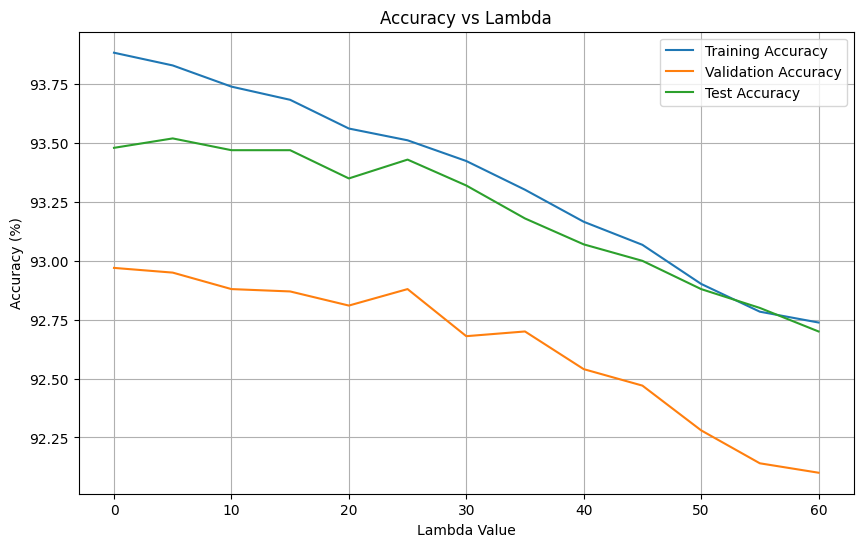

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, train_accuracies, label='Training Accuracy')
plt.plot(lambda_values, validation_accuracies, label='Validation Accuracy')
plt.plot(lambda_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Lambda Value')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Lambda')
plt.legend()
plt.grid(True)
plt.savefig("Extranalysis_1", bbox_inches="tight")
plt.show()

We can see that accuracies are higher when lambda is ranging from 0 to 10

taking 10 as lambda and changing the hidden nodes to check the train/validation/test accuracies and run time

In [101]:
# Set the number of nodes in input and output units
n_input = train_data.shape[1]
n_class = 10  # Number of classes

# Lambda value to keep fixed
lambdaval = 10

# Hidden node values to test
hidden_nodes_vals = [4, 8, 12, 16, 20, 50]

train_hidden_accuracies = []
validation_hidden_accuracies = []
test_hidden_accuracies = []
runtime_values=[]

# Results storage: list to hold hidden nodes, train accuracy, validation accuracy, test accuracy, and runtime for each setting
results_hidden = []

# Iterate over different hidden node values
for n_hidden in hidden_nodes_vals:
    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Set up arguments and options for training
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    opts = {'maxiter': 50}  # Preferred max iteration count

    # Train the neural network
    start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    runtime = time.time() - start_time

    # Reshape nn_params into weight matrices w1 and w2
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Test on training, validation, and testing data

    train_pred = nnPredict(w1, w2, train_data)
    train_accuracy = 100 * np.mean((train_pred == train_label).astype(float))
    train_hidden_accuracies.append(train_accuracy)

    val_pred = nnPredict(w1, w2, validation_data)
    val_accuracy = 100 * np.mean((val_pred == validation_label).astype(float))
    validation_hidden_accuracies.append(val_accuracy)

    test_pred = nnPredict(w1, w2, test_data)
    test_accuracy = 100 * np.mean((test_pred == test_label).astype(float))
    test_hidden_accuracies.append(test_accuracy)

    runtime_values.append(runtime)
    # Store results
    results_hidden.append((n_hidden, train_accuracy, val_accuracy, test_accuracy, runtime))

# Print summary of results
print("\nHidden Nodes values, corresponding train, validation, test accuracies, and runtime:")
for result in results_hidden:
    print(f'Hidden Nodes: {result[0]}, Train Accuracy: {result[1]:.2f}%, '
          f'Validation Accuracy: {result[2]:.2f}%, Test Accuracy: {result[3]:.2f}%, Runtime: {result[4]:.2f}s')



Hidden Nodes values, corresponding train, validation, test accuracies, and runtime:
Hidden Nodes: 4, Train Accuracy: 76.83%, Validation Accuracy: 74.89%, Test Accuracy: 76.25%, Runtime: 38.55s
Hidden Nodes: 8, Train Accuracy: 89.71%, Validation Accuracy: 89.47%, Test Accuracy: 89.42%, Runtime: 33.60s
Hidden Nodes: 12, Train Accuracy: 91.56%, Validation Accuracy: 90.72%, Test Accuracy: 91.20%, Runtime: 28.22s
Hidden Nodes: 16, Train Accuracy: 93.03%, Validation Accuracy: 92.53%, Test Accuracy: 92.78%, Runtime: 34.42s
Hidden Nodes: 20, Train Accuracy: 93.74%, Validation Accuracy: 92.88%, Test Accuracy: 93.47%, Runtime: 35.89s
Hidden Nodes: 50, Train Accuracy: 94.94%, Validation Accuracy: 94.53%, Test Accuracy: 94.87%, Runtime: 50.18s


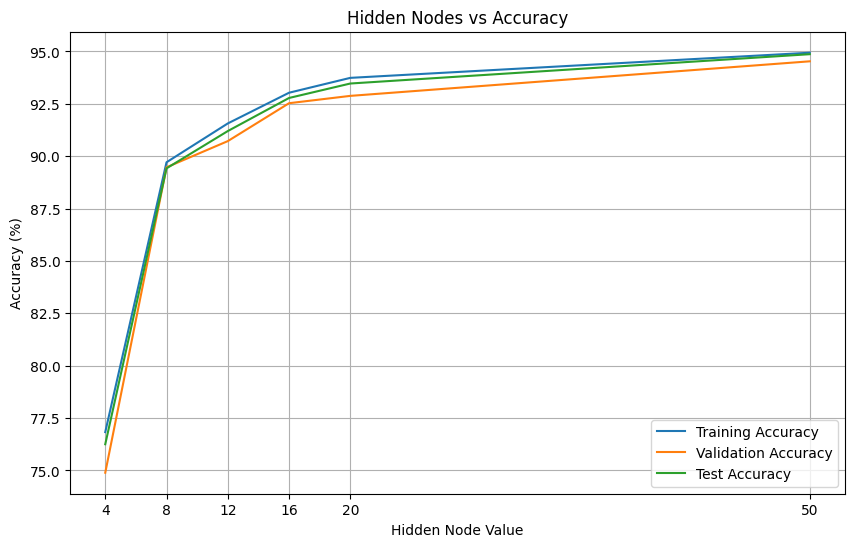

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(hidden_nodes_vals, train_hidden_accuracies, label='Training Accuracy')
plt.plot(hidden_nodes_vals, validation_hidden_accuracies, label='Validation Accuracy')
plt.plot(hidden_nodes_vals, test_hidden_accuracies, label='Test Accuracy')
plt.xlabel('Hidden Node Value')
plt.ylabel('Accuracy (%)')
plt.title('Hidden Nodes vs Accuracy')
plt.legend()
plt.grid(True)

# Set x-ticks to specific hidden node values
plt.xticks(hidden_nodes_vals)
plt.savefig("Extranalysis_2", bbox_inches="tight")
plt.show()


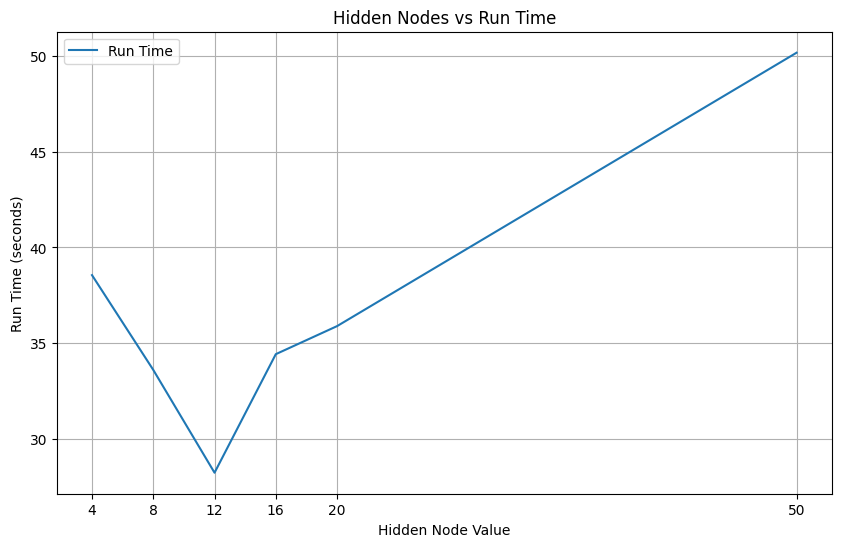

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(hidden_nodes_vals, runtime_values, label='Run Time')  # Added label for the legend
plt.xlabel('Hidden Node Value')
plt.ylabel('Run Time (seconds)')
plt.title('Hidden Nodes vs Run Time')
plt.legend()  # Display the legend
plt.grid(True)

# Set x-ticks to specific hidden node values
plt.xticks(hidden_nodes_vals)
plt.savefig("Extranalysis_3", bbox_inches="tight")
plt.show()
